In [1]:
import sys
#import ftplib
import dask
from dask.diagnostics import ProgressBar
import xarray as xr
import numpy as np
import datetime 
import time
from datetime import datetime 
import matplotlib
import matplotlib.pyplot as plt

#import scipy.stats as stats
import pandas as pd
#import seaborn as sns
##import sklearn
#from sklearn.metrics import median_absolute_error, mean_squared_error,r2_score
#from sklearn.linear_model import LinearRegression, RANSACRegressor, HuberRegressor


import pyOptimalEstimation as pyOE

import cartopy
import cartopy.crs as ccrs
from cmocean import cm as cmo

import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from glob import glob

#import imageio

#from pathlib import Path

#from netCDF4 import Dataset

import gc, psutil

In [2]:
#import multiprocessing
#multiprocessing.cpu_count()

In [3]:
#sys.path.append('/nobackup/users/echeverr/Git/SatOpEst/support') # where supporting_routines_m live
sys.path.append('/home/mario/Documents/work/code/git/SatOpEst/support') # where supporting_routines_m live
#sys.path.append('/usr/people/echeverr/Data_m/support') # where supporting_routines_m live

import supporting_routines_m 

import os

#rttov_installdir = '/usr/people/echeverr/Documents/code/nwpsaf/rttov13'
rttov_installdir = '/home/mario/myLibs/rrtov13/rttov130'

sys.path.append(rttov_installdir+'/wrapper')
import pyrttov


#current_directory = os.getcwd()
#os.environ["CARTOPY_USER_BACKGROUNDS"] = os.path.join(current_directory,'/nobackup/users/echeverr/py_tests/earthpy_example/images')

In [4]:
p = psutil.Process()



#BT_dir = '/nobackup/users/echeverr/data/cmsaf/ssmis/F16/'
BT_dir = '/home/mario/Data/CMSAF/ssims/F16/'
#BT_dir = '/usr/people/echeverr/Data_m/TB_F16/'

BT_dir2 = BT_dir+'V1/'

In [5]:
#BT_file = '*.nc'
BT_file = 'BTRin20140909000000324SSF1601GL'

BT_file2 = BT_file+'_v1'

# Chunking the dataset (for 30 mins 10,10 works well (in my laptop, Mario); 
# if increase minutes times x, then increase chunk_size_time times x as well (avoids memory problems))
chunk_size_time =  10 # 420 for half day
chunk_size_s_a_t = 10

# user input:
init_date = np.datetime64('2014-09-09T00:25:00.000') 
end_date = np.datetime64('2014-09-09T00:30:00.000')
#init_date = np.datetime64('2014-09-09T00:00:00.000') 
#end_date = np.datetime64('2014-09-09T01:59:59.000')
#init_date = np.datetime64('2014-09-09T00:00:00.000') 
#end_date = np.datetime64('2014-09-09T23:59:59.000')

# Perform chisquare tests available in pyOptimalEstimation or not:
performTests = True

#Latitude bands:
#lat_bands2 = np.array([-90.0,-40.0,-40.0,0.0,0.0,40.0,40.0,90.0])

# Directories for lat_bands:

#aprioLowCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/lower_cap/'
#aprioLowMidCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/lowmid_cap/'
#aprioUpMidCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/upmid_cap/'
#aprioUpCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/upper_cap/'

#aprioLowCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/lower_cap/'
#aprioLowMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/lowmid_cap/'
#aprioUpMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/upmid_cap/'
#aprioUpCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/upper_cap/'

#dir_bands2 = np.array([aprioLowCapDir,aprioLowMidCapDir,aprioUpMidCapDir,aprioUpCapDir])

In [6]:
#xr.open_dataset(BT_dir2+BT_file2+'5chan'+'.nc')


In [7]:
import pyproj

import pyresample
from pyresample import create_area_def, load_area, data_reduce, utils, AreaDefinition
from pyresample.geometry import SwathDefinition
from pyresample.kd_tree import resample_nearest

In [8]:
# returns the directory (str) corrisponding to the band where "lat" is located
def get_band(lat,dir_bands,lat_bands):
    i=0
    band_out=None
    for band in dir_bands: 
        if(np.logical_and(lat >= lat_bands[i][0], lat <= lat_bands[i][1])):
            band_out = band
        i+=1
    if(band_out==None):
        print("Error in lat:")
        print(lat)
        print(type(lat))
        sys.stderr.write("Error in lat")
        sys.exit(1)
        
    return band_out


def split_file_name(f):
    aux1 = f.split(".")[0].split("0_")
    aux2 = aux1[1].split("_")
    season = aux1[0]
    aORb = aux2[0]
    meanORcov = aux2[1]
    return season, aORb, meanORcov

def get_mean_covs(directory,inputSeason):
# very badly programed look-up table: it will look
# for the files corrisponding to a given inputSeason 
# and return means and covariances for both state vector (a)
# and parameters vector (b).
    files = os.listdir(directory)
    for f in files:
        #print(f)
        season, aORb, meanORcov = split_file_name(f)
        if(inputSeason==season):
            if(aORb=='a'):
                if(meanORcov=='mean'):
                    xa = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                elif(meanORcov=='cov'):   
                    Sa = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                else:
                    print('Something went wrong, check:')
                    print(directory+f)
            elif(aORb=='b'):
                if(meanORcov=='mean'):
                    xb = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                elif(meanORcov=='cov'):   
                    Sb = pd.read_csv(directory+f, 
                                     index_col=0).rename_axis('state', 
                                                              axis=0).rename_axis('stateT', 
                                                                                  axis=1)
                else:
                    print('Something went wrong, check:')
                    print(directory+f)                
            
        
    return xa,Sa,xb,Sb   

get_mean_covs_vec = np.vectorize(get_mean_covs, otypes=[pd.core.frame.DataFrame,
                                                        pd.core.frame.DataFrame,
                                                        pd.core.frame.DataFrame,
                                                        pd.core.frame.DataFrame])

def reshape4profiles(profiles):
    # "profiles" is a numpy array
    # "profiles" can contain 1 or more profiles
    # "profiles" has dimensions (nlevels, nprofiles)
    # "outProfiles" has dimensions (nprofiles,nlevels) (as needed in RTTOV)
    
    if (len(profiles.shape)==1):
        outProfiles = profiles.reshape(1,profiles.shape[0]).copy()
    else:
        outProfiles = profiles.T.copy() #profiles.reshape(profiles.shape[1]
            #                          ,profiles.shape[0]) 
    return outProfiles  

def expand2nprofiles(n, nprof):
    # Transform 1D array to a [nprof, nlevels] array
    outp = np.empty((nprof, len(n)), dtype=n.dtype)
    for i in range(nprof):
        outp[i, :] = n[:]
    return outp

def forward_b_init(pressure, salinity, lat, long, datetime_obs64, 
                   zenithAngle, myProfiles):
    
    if (len(pressure.shape)==1):
        nprofiles = 1
    else:
        nprofiles =  pressure.shape[1]
    
    # The rest of the code uses datetime64 format (numpy), but I have to pass the obs date as integers to RTTOV
    datetime_obs = supporting_routines_m.datetime64_to_datetime(datetime_obs64)
    
    s2m = np.zeros((nprofiles,6), dtype=np.float64) # s2m has 6 elements (docs RTTOV)
    
    angles = np.zeros((nprofiles,4), dtype=np.float64) # angles has 4 elements (docs RTTOV)
    angles[:,0] = zenithAngle
    
    
    # for RTTOV 13 skin is 9 elements long:
    skin = np.zeros((nprofiles,9), dtype=np.float64) # skin has 9 elements (docs RTTOV)
    skin[:,1] = salinity
        
    surftype = np.zeros((nprofiles,2), dtype=np.int32) # surftype has 2 elements (docs RTTOV)
    surftype[:,:] = 1 # [sea, ocean] Harcoded for now, TODO *** mario
    
    
    surfgeom = np.zeros((nprofiles,3), dtype=np.float64) # surfgeom has 3 elements (docs RTTOV)
    surfgeom[:,0] = lat
    surfgeom[:,1] = long
    # surfgeom[:,2]=0 # elevation harcoded to 0 for now, TODO *** mario
    
    date_times = np.zeros((nprofiles,6), dtype=np.int32) # date_times has 6 elements (docs RTTOV)
    date_times[:,0] = datetime_obs.year
    date_times[:,1] = datetime_obs.month
    date_times[:,2] = datetime_obs.day
    date_times[:,3] = datetime_obs.hour
    date_times[:,4] = datetime_obs.minute
    date_times[:,5] = datetime_obs.second
    
    
    myProfiles.GasUnits = 1  # kg/kg (see RTTOV doc. for other options) # Harcoded for now, TODO *** mario
    myProfiles.P = reshape4profiles(pressure) 
    myProfiles.S2m = s2m
    myProfiles.Angles = angles
    myProfiles.Skin = skin
    myProfiles.SurfType = surftype
    myProfiles.SurfGeom = surfgeom
    myProfiles.DateTimes = date_times 


def forwardRT(X, myProfiles_a, ssmiRttov_a, channels_list=None):
    
    # TODO: Add assertions, tests *** mario

    # X contains T, Q and W10, lets split the vector
    #temperature, humidity, wind10m = supporting_routines_m.splitX(X)
    
    # if wind speed in components:

    #temperature, humidity, u10m, v10m, bp2m, bt2m, btsk \
    #= supporting_routines_m.splitX_all(X)
    
    #NEW
    # Wind u, v:
    #temperature, humidity, u10m, v10m, t2m, tsk, sp \
    #= supporting_routines_m.splitX_all_2(X)
    # Wind W:
    temperature, humidity, w10m, t2m, tsk, sp \
    = supporting_routines_m.splitX_all_2W_np(X)
    #= supporting_routines_m.splitX_all_2W(X)    
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.
    # or abs_humidity? *** note mario

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = sp # surface pressure
    myProfiles_a.S2m[:,1] = t2m  # 2m temperature
    myProfiles_a.Skin[:,0] = tsk 
    
    # if wind in components:
    #myProfiles_a.S2m[:,3] = reshape4profiles(
    #    u10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, u component
    #myProfiles_a.S2m[:,4] = reshape4profiles(
    #    v10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, v component 
    
    # Wind W:
    myProfiles_a.S2m[:,3] = 0.7071*w10m  #  10m windspeed
    myProfiles_a.S2m[:,4] = myProfiles_a.S2m[:,3]    
   
    ssmiRttov_a.Profiles = myProfiles_a
    
    #ssmiRttov_a.SurfEmisRefl[:,:,:] = -1. # need to "reset" to -1 every time RTTOV is called; 
    # -1 indicates to RTTOV to use internal values for surface emissivity.

    try:
        ssmiRttov_a.runDirect(channels_list)
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)    
        
    #print(ssmiRttov.BtRefl[:, :].shape)
    #print(ssmiRttov.BtRefl[:, :])
    
    if(ssmiRttov_a.BtRefl[:, :].shape[0]==1):
        TB = ssmiRttov_a.BtRefl[0, :].T
    else:
        TB = ssmiRttov_a.BtRefl[:, :].T
    
    return TB

def rttovK(X, perturbation, y_var, myProfiles_a, ssmiRttov_a, channels_list=None):
    
    # TODO: Add assertions, tests *** mario

    #temperature, humidity, u10m, v10m, t2m, tsk, sp \
    #= supporting_routines_m.splitX_all_2(X)

    # Wind W:
    temperature, humidity, w10m, t2m, tsk, sp \
    = supporting_routines_m.splitX_all_2W_np(X) 
    #= supporting_routines_m.splitX_all_2W(X)        
    
    # humdity is in log10 scale, convert to linear in kg/kg
    humidity = (10**humidity) / 1000.

    myProfiles_a.T = reshape4profiles(temperature.to_numpy(dtype=np.float64))  
    myProfiles_a.Q = reshape4profiles(humidity.to_numpy(dtype=np.float64))  

    myProfiles_a.S2m[:,0] = sp # surface pressure
    myProfiles_a.S2m[:,1] = t2m # 2m temperature
    myProfiles_a.Skin[:,0] = tsk 
    
    # if wind in components:
    #myProfiles_a.S2m[:,3] = reshape4profiles(
    #    u10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, u component
    #myProfiles_a.S2m[:,4] = reshape4profiles(
    #    v10m.to_numpy(dtype=np.float64)).flatten()  #  10m windspeed, v component   
    
    # Wind W:
    myProfiles_a.S2m[:,3] = 0.7071*w10m  #  10m windspeed
    myProfiles_a.S2m[:,4] = myProfiles_a.S2m[:,3] 
    
    ssmiRttov_a.Profiles = myProfiles_a
    
    #ssmiRttov_a.SurfEmisRefl[:,:,:] = -1. # need to "reset" to -1 every time RTTOV is called; 
    # -1 indicates to RTTOV to use internal values for surface emissivity.
    
    try:
        ssmiRttov_a.runK(channels_list)
    except pyrttov.RttovError as e:
        sys.stderr.write("Error running RTTOV direct model: {!s}".format(e))
        sys.exit(1)
    
    # Create Jacobian Dataframe skeleton:
    #jacx = pd.DataFrame(index=y_var, columns=X.index)  
    
    # Fill-in Jacobian Dataframe
    #jacx = supporting_routines_m.mergeX_all_2W(jacx.T, X, 
    #                                        ssmiRttov_a,
    #                                        perturbation = perturbation, 
    #                                        LogHum=True)

    merged = supporting_routines_m.mergeX_all_2W_np(X, 
                                            ssmiRttov_a,
                                            perturbation = perturbation, 
                                            LogHum=True)
    return merged.T
    #return jacx.T.to_numpy(dtype=np.float64) 


def sleep_and_print_mem(title, sleep=3):
    time.sleep(sleep)
    print("\n" + title + " : " +  "%0.2f MB" % (p.memory_info().rss / 1e6)
         + "   " + "=" * 49)
    
def month2season(month):
    seasons = [
        'DJF',
        'MAM',
        'JJA',
        'SON',
    ]
    season = seasons[month-1] # month is 1 based index while seasons array needs 0 based indexing
   
    return season

month2season_vec = np.vectorize(month2season, otypes=[str])    

In [9]:
def rttovStrucInit():
    # Set knobs for use of OpenMP in RTTOV

    NthreadsF = 1  # Number of threads for forward model  #os.cpu_count()
    NthreadsFM = 4 # Number of threads for forward model (in case of multiple profiles, used in) #os.cpu_count()
    NprofsPerCallFM = 40 # ?Roughly speaking number of variables (e.g. 279) / Number of threads (e.g. 8)
    # Create instance of Profiles class; 
    # it's a container of the input atmospheric state that RTTOV will simulate



    #  Create instance of RTTOV
    ssmiRttov = pyrttov.Rttov()

    #chan_list_ssmi = (12,13,14,15,16,17,18) #(1,12,13,14,15,16) #  #

    # Define instrument (FileCoef):
    ssmiRttov.FileCoef = '{}/{}'.format(rttov_installdir,
                                    "rtcoef_rttov13/rttov7pred54L/rtcoef_dmsp_16_ssmis.dat")

    # Load the instruments: for HIRS and MHS do not supply a channel list and
    # so read all channels
    try:
        ssmiRttov.loadInst() #chan_list_ssmi
    except pyrttov.RttovError as e:
        sys.stderr.write("Error loading instrument(s): {!s}".format(e))
        sys.exit(1)

    # Some settings
    ssmiRttov.Options.AddInterp = True
    # ssmiRttov.Options.InterpMode = 2
    ssmiRttov.Options.CO2Data = False
    ssmiRttov.Options.VerboseWrapper = False
    ssmiRttov.Options.DoCheckinput = False
    ssmiRttov.Options.UseQ2m = False
    ssmiRttov.Options.ApplyRegLimits = True
    ssmiRttov.Options.Verbose = False
    ssmiRttov.Options.FastemVersion = 6
    ssmiRttov.Options.Switchrad = True
    ssmiRttov.Options.Nthreads = NthreadsF

    # *********************************
    # *********************************
    return ssmiRttov

In [10]:
# ONLY FOR MULTIPLE PROFILES CALL TESTING

def rttovMStrucInit():
    
    NthreadsFM = 4 # Number of threads for forward model (in case of multiple profiles, used in) #os.cpu_count()
    NprofsPerCallFM = 40 # ?Roughly speaking number of variables (e.g. 279) / Number of threads (e.g. 8)
    ssmiRttovM = pyrttov.Rttov()

    # SSMIS:
    ssmiRttovM.FileCoef = '{}/{}'.format(rttov_installdir,
                                    "rtcoef_rttov13/rttov7pred54L/rtcoef_dmsp_16_ssmis.dat")

    ssmiRttovM.Options.AddInterp = True
    #ssmiRttovM.Options.InterpMode = 2
    ssmiRttovM.Options.CO2Data = False
    ssmiRttovM.Options.VerboseWrapper = False
    ssmiRttovM.Options.DoCheckinput = False
    ssmiRttovM.Options.UseQ2m = False
    ssmiRttovM.Options.ApplyRegLimits = True
    ssmiRttovM.Options.Verbose = False
    ssmiRttovM.Options.FastemVersion = 6 
    ssmiRttovM.Options.Nthreads = NthreadsFM
    #ssmiRttovM.Options.NprofsPerCall = NprofsPerCallFM
    ssmiRttovM.Options.Switchrad = True

    # Load the instruments: for HIRS and MHS do not supply a channel list and
    # so read all channels
    try:
        ssmiRttovM.loadInst()
    except pyrttov.RttovError as e:
        sys.stderr.write("Error loading instrument(s): {!s}".format(e))
        sys.exit(1)
    return ssmiRttovM

In [11]:
# Add init function:


def init_retrieval_data(time_i, lat, lon, 
                        channels_list,
                        channel_uncertainty, BT,
                        zenithAngle, #dir_bands2,
                        #lat_bands2
                       ):  

    nprofiles = 1  # This is hardcoded (we use RTTOV within OE, workin on a single profile per OE)
    nlev = 37 # TODO: this needs to be read from the apriori data (covariances and means) 
    myProfiles = pyrttov.Profiles(nprofiles, nlev)
    ssmiRttov = rttovStrucInit()  
    ssmiRttovM=None  # rttovMStrucInit() 

    aprioLowCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/lower_cap/'
    aprioLowMidCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/lowmid_cap/'
    aprioUpMidCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/upmid_cap/'
    aprioUpCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/upper_cap/'
    
    #aprioLowCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/lower_cap/'
    #aprioLowMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/lowmid_cap/'
    #aprioUpMidCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/upmid_cap/'
    #aprioUpCapDir = '/nobackup/users/echeverr/data/ECMWF_era5/hourly_ERA5/mean_cov/upper_cap/'
    
    #aprioLowCapDir = '/usr/people/echeverr/Data_m/mean_cov/lower_cap/'
    #aprioLowMidCapDir = '/usr/people/echeverr/Data_m/mean_cov/lowmid_cap/'
    #aprioUpMidCapDir = '/usr/people/echeverr/Data_m/mean_cov/upmid_cap/'
    #aprioUpCapDir = '/usr/people/echeverr/Data_m/mean_cov/upper_cap/'
    

    # list of directories contaning covariances and means; each dir contains one geographical zone 
    # Geo. zones are divided in latitude strips: [-90,-40), [-40,0), [0,+40), [+40,+90]; lon. [-180,+180) for all
    
    dir_bands = [aprioLowCapDir,aprioLowMidCapDir,aprioUpMidCapDir,aprioUpCapDir] # 
    lat_bands = [[-90.0,-40.0],[-40.0,0.0],[0.0,40.0],[40.0,90.0]]   # 

    #dir_bands = dir_bands2.reshape((4,)).tolist()
    #lat_bands = lat_bands2.reshape((4,2)).tolist()
    
    months = (time_i.astype('datetime64[M]').astype(int) % 12 + 1)%12 // 3 + 1
    season = month2season_vec(months)
   
    
    # Load Atlases: (if any)    
    #ssmiRttov.SurfEmisRefl = np.zeros((
    #    4, nprofiles, len(channels_list)), dtype=np.float64)
            
    y_obs = pd.Series(BT,
                index=channels_list
                     )            
            
    # TODO Sy needs to be loaded from somewhere according to the channels_list: ***********
            
    # Channels 12-16 (values from Deblonde-English 2003) (sigma or std)
    y_noise = pd.Series(channel_uncertainty,
                        index=channels_list)
                            
    # Variance values > std**2
    S_y = pd.DataFrame(
                np.diag(y_noise.values**2),
                index=channels_list,
                columns=channels_list,
    )
    # TODO Sy needs to be loaded from somewhere according to the channels_list  ***********
            
    datetime_obs = time_i #.values
    salinity = 35 # hardcoded, not good; TODO Mario
            
    band = get_band(lat,dir_bands,lat_bands) # gets the directory for the band where 'lat' is located
    xa,Sa,xb,Sb = get_mean_covs(band, season) # gets mean and covariances for the band and season
            
    # reverse order in x and S (profile variables are reordered from low pressure to high) 
    Sb = Sb.iloc[::-1,::-1]
    Sa = Sa.iloc[::-1,::-1]
    xb = xb.iloc[::-1].squeeze() # convert means from dataframe to series
    xa = xa.iloc[::-1].squeeze()
            
    # Get the pressure per level ; TODO: this needs to be independent of the variable (e.g. xb in this case)
    xb_index = [float(i.split('_')[0]) for i in xb.index if i.endswith('temp')]
    Pressure = np.array(xb_index).reshape(len(xb_index),1)
     
    new_index = []
    for i in xa.index:
        new_index.append(i.split('_')[1])           
    x_vars = np.array(new_index) #xa.index.values

    new_index = []
    for i in xb.index:
        new_index.append(i.split('_')[1])           
    b_vars = np.array(new_index) #xb.index.values           
    
    nlev = len([i for i in xb.index if i.endswith('temp')]) # number of levels in profile quantities


    # forward_b_init fills "myProfiles" with the "fixed" parameters for the RTTOV simulation.
    # The forward model F(x,b), RTTOV in our case, has two "parameters": x and b
    # x is the state vector that is being retrieved (as such it is allowed to change during the retrieval)
    # b contains all other parameters that are fixed during the retrieval (everything else that is not being retrieved)

    forward_b_init(Pressure, salinity,
                   lat, lon, datetime_obs, zenithAngle, myProfiles)
    
    # Define dictionary of parameters for the forward model:

    forwardKwArgs = {"myProfiles_a" : myProfiles, 
                    "ssmiRttov_a" : ssmiRttov,
                    "channels_list":channels_list.tolist()}    
    

    
    # Define dictionary of parameters for the forward model (Multiple profiles case):
    
    if ssmiRttovM != None:   # if an RTTOV instance for multiple profiles has been defined
        
        # Initialize multiple profiles for using a single call to RTTOV
        # This is to be passed to the Jacobian function inside pyOpEst:
        # The Jacobian is needed per parameter (len(xa.index)+len(xb.index))

        nProfilesM = len(xa.index)+len(xb.index) # total number of parameters (x and b)
            
        # Load Atlases for Multiple profiles: (if any)    
        #ssmiRttovM.SurfEmisRefl = np.zeros((
        #    4, nProfilesM, len(channels_list)), dtype=np.float64) # RTTOVv12 used (2,nprof,nchan)
                   
        myProfilesM = pyrttov.Profiles(nProfilesM, nlev) # 

        #press2 = np.ones((nlev, nProfilesM))*Pressure # Pressure:(nlev,1)
      
        # Initialize profile datastructure for use in Jacobian computation:        
        forward_b_init(np.ones((nlev, nProfilesM))*Pressure, salinity,
                       lat, lon, datetime_obs, zenithAngle, myProfilesM) 
    
        forwardKwArgsM = {"myProfiles_a" : myProfilesM, 
        "ssmiRttov_a" : ssmiRttovM,
        "channels_list":channels_list.tolist()}
    else:
        forwardKwArgsM = None    # if not, then use only the single profile RTTOV instance;
                                 # this results in a much slower Jacobian calculation.
        
        
    # Create OE object:
    
    oe_ref = pyOE.optimalEstimation( # oe_1 if windDisambiguation used
        x_vars=x_vars, # state variable names
        x_a=xa.to_numpy(),  # a priori
        S_a=Sa.to_numpy(), # a priori uncertainty
        y_vars=channels_list,  # measurement variable names
        y_obs=y_obs, # observations
        S_y=S_y.to_numpy(), # observation uncertainty
        forward=forwardRT, # forward Operator
        userJacobian=rttovK, # RTTOV's K model operator
        forwardKwArgs=forwardKwArgs, # additonal function arguments
        #multipleForwardKwArgs=forwardKwArgsM, # additonal function arguments for jacobian 
        #x_truth=x_truth, # true profile
        b_vars=b_vars,   # Parameter vector variable names
        b_p=xb.to_numpy(),        # Parameter vector 
        S_b=Sb.to_numpy(),        # Parameters error covariance matrix 
        perturbation=0.01,
        verbose=False
    )
    return oe_ref


In [12]:
# Load TB dataset:

times = xr.open_dataset(BT_dir2+BT_file2+'5chan'+'.nc').time
print(type(times))
# nearest to user input in dataset:
init_date = times.sel(time=init_date, method = "nearest")
end_date = times.sel(time=end_date, method = "nearest")

times = None

DS_CMSAF_ocean = xr.open_dataset(BT_dir2+BT_file2+'5chan'+'.nc'
                                    ).sel(time=slice(init_date,end_date),
                                          #scene_channel=np.array([11,12,14,15]),
                                         ).chunk({"time": chunk_size_time,
                                             "scene_across_track": chunk_size_s_a_t})

#DS_CMSAF_ocean_all = xr.open_dataset(BT_dir2+BT_file2+'5chan'+'.nc'
#                                    ).chunk({"time": chunk_size_time,
#                                             "scene_across_track": chunk_size_s_a_t})
# nearest to user input in dataset:
#init_date = DS_CMSAF_ocean_all.time.sel(time=init_date, method = "nearest")
#end_date = DS_CMSAF_ocean_all.time.sel(time=end_date, method = "nearest")

# Dataset over the ocean ready to be analyzed:
#DS_CMSAF_ocean = DS_CMSAF_ocean_all.sel(time=slice(init_date,end_date)
#                                       ).chunk({"time": chunk_size_time,"scene_across_track": chunk_size_s_a_t})

DS_CMSAF_ocean['wind'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Near surface wind speed (NSWP)',
                    'units'     : 'm/s'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})

DS_CMSAF_ocean['wind_err'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'NSWP uncertainty',
                    'units'     : 'm/s'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})

if(performTests):
    sizeResults = 6 # parameter on apply_ufunc
    workerMemLimit = '4GB' # For cluster definition (works well for 1 hour of CMSAF data)
    DS_CMSAF_ocean['chiSquareTest1'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with observation in Y space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    DS_CMSAF_ocean['chiSquareTest2'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Observation agrees with prior in Y space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    DS_CMSAF_ocean['chiSquareTest3'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with prior in Y space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    DS_CMSAF_ocean['chiSquareTest4'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with priot in X space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
    
else:
    sizeResults = 2 # parameter on apply_ufunc
    workerMemLimit = '2GB' # For cluster definition (works well for 1 hour of CMSAF data)
    
DS_CMSAF_ocean

<class 'xarray.core.dataarray.DataArray'>


<xarray.Dataset>
Dimensions:              (time: 159, scene_across_track: 90, scene_channel: 5)
Coordinates:
  * scene_across_track   (scene_across_track) int32 1 5 9 13 ... 345 349 353 357
  * scene_channel        (scene_channel) int64 11 12 13 14 15
  * time                 (time) datetime64[ns] 2014-09-09T00:25:00 ... 2014-0...
Data variables: (12/13)
    lat                  (time, scene_across_track) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    lon                  (time, scene_across_track) float64 dask.array<chunksize=(10, 10), meta=np.ndarray>
    eia                  (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    sft                  (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    tb                   (time, scene_across_track, scene_channel) float32 dask.array<chunksize=(10, 10, 5), meta=np.ndarray>
    global_channel_ID    (scene_channel) int32 dask.array<chunksize=(5,), meta=np.ndarray>
    ...                   ...
    wind                 (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    wind_err             (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    chiSquareTest1       (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    chiSquareTest2       (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    chiSquareTest3       (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
    chiSquareTest4       (time, scene_across_track) float32 dask.array<chunksize=(10, 10), meta=np.ndarray>
Attributes:
    title:                 Environmental Scene 1
    comment:               feedhorn channels: h19, v19, v22
    elevation_offset_deg:  0.4
    azimuth_offset_deg:    -0.3

In [13]:
#DS_CMSAF_ocean.global_channel_ID.compute()
#dask.visualize(DS_CMSAF_ocean.channel_uncertainty, filename='ch_ID_NO_chunks.eps')

In [14]:
#dask.visualize(DS_CMSAF_ocean.tb, filename='tb_tasks_chunks.eps')

In [15]:
#def testFunc(tb):
#    tb2 = tb[0]
#    return tb2

def retrieveWind(time, tb, global_channel,
                 channel_uncertainty,
                 lat, lon, eia, #dir_bands2,
                 #lat_bands2, 
                 performTests,
                ):
    
    wind = np.full(lat.shape, np.nan, dtype=np.float32)
    wind_err = np.full(lat.shape, np.nan, dtype=np.float32)
    if(performTests):
        chiSquareTest1 = np.full(lat.shape,np.nan,dtype=np.float32)
        chiSquareTest2 = np.full(lat.shape,np.nan,dtype=np.float32)
        chiSquareTest3 = np.full(lat.shape,np.nan,dtype=np.float32)
        chiSquareTest4 = np.full(lat.shape,np.nan,dtype=np.float32)

    if((~np.isnan(lat))and(~np.any(np.isnan(tb)))):  # Input dataset has been filtered for sea-land flag (so both, lat and lon are valid or nan)
        
        oe_ref = init_retrieval_data(time,
                                     lat, lon,
                                     global_channel,
                                     channel_uncertainty,
                                     tb,
                                     eia,
                                     #dir_bands2,
                                     #lat_bands2
                                    )

        oe_ref.doRetrieval()     
    
        if oe_ref.converged:  # 
            w10m, _ = supporting_routines_m.splitX_all_2W_np_xvars(oe_ref.x_op)
            w10m_err, _ = supporting_routines_m.splitX_all_2W_np_xvars(oe_ref.x_op_err)
    
            wind =  w10m #.values.item()
            wind_err =  w10m_err #.values.item()
            
            if(performTests):      
                #aux_test = oe_ref.chiSquareTest()
                chiSquareTest1 = np.float32(oe_ref.chiSquareTest()[0][0])
                chiSquareTest2 = np.float32(oe_ref.chiSquareTest()[0][1])
                chiSquareTest3 = np.float32(oe_ref.chiSquareTest()[0][2])
                chiSquareTest4 = np.float32(oe_ref.chiSquareTest()[0][3])
                #print(aux_test[0][0])
                #print(aux_test[0][1])
                #chiSquareTest1 = np.float32(aux_test[0][0])
                #chiSquareTest2 = np.float32(aux_test[0][1])
                #chiSquareTest3 = np.float32(aux_test[0][2])
                #chiSquareTest4 = np.float32(aux_test[0][3])
    
    if(performTests):
        out = np.array([wind, wind_err,
                    chiSquareTest1,
                    chiSquareTest2,
                    chiSquareTest3,
                    chiSquareTest4,])
    else:
        out = np.array([wind, wind_err,])
        
    return out  

            

In [16]:
# Analysis (retrievals)

#os.environ["MALLOC_TRIM_THRESHOLD_"] = "0" #"65536" #
from dask.distributed import Client, progress, LocalCluster

startTimeAll = time.time()

# Group per hour or couple of hours in order to avoid having memory issues in workers:

DS_CMSAF_ocean_grouped = DS_CMSAF_ocean.resample(time='1H') #.groupby("time.hour")
i=0

#client = Client("tcp://10.120.79.130:8786")

for hour_name, hour_group in DS_CMSAF_ocean_grouped:
    
    startTimeHour = time.time()
    
    #hour_group = hour_group.chunk({"time": chunk_size_time,
    #                               "scene_across_track": chunk_size_s_a_t})

    with LocalCluster(threads_per_worker = 1, 
                      n_workers = 8, memory_limit = workerMemLimit,
                      processes=True
                     ) as cluster, Client(cluster) as client:
        
        out_wind = xr.apply_ufunc(retrieveWind,
                                  hour_group.time,
                                  hour_group.tb,
                                  hour_group.global_channel_ID,
                                  hour_group.channel_uncertainty,
                                  hour_group.lat, hour_group.lon,
                                  hour_group.eia,# dir_bands2,
                                  #lat_bands2,
                                  performTests,
                                  input_core_dims=[[], 
                                               ["scene_channel"], 
                                               ["scene_channel"],
                                               ["scene_channel"],[],[],[],[],#[],[],
                                              ],
                                  exclude_dims= set(("scene_channel",)),
                                  output_core_dims=[
                                      ["results"],
                                  ],
                                  dask="parallelized",
                                  output_dtypes=[hour_group.wind.dtype],
                                  #output_sizes={"results": sizeResults}, # 6 if performTests=True, 2 otherwise
                                  dask_gufunc_kwargs={
                                      'output_sizes':{
                                          "results": sizeResults}},
                                  vectorize=True
                                 ).compute().chunk({"time": chunk_size_time,
                                                    "scene_across_track": chunk_size_s_a_t})
        
        #dask.visualize(out_wind, filename='retrieval_tasks.png')
        #out_wind.compute().chunk({"time": chunk_size_time,
        #                          "scene_across_track": chunk_size_s_a_t})   
    print("%.2f s , Time_Hour" % (time.time()-startTimeHour)) 

    if(i==0):
        out_wind_1 = out_wind    
    else:
        out_wind_1 = xr.concat((out_wind_1, out_wind), dim = "time")

    print("Time group:")
    print(i)
    print("Done!")
    i+=1
    #client.restart()

# Done with processing, close this client:
#client.close()
    
DS_CMSAF_ocean["wind"].data = out_wind_1.data[:,:,0]
DS_CMSAF_ocean["wind_err"].data = out_wind_1.data[:,:,1]
if(performTests):
    DS_CMSAF_ocean["chiSquareTest1"].data = out_wind_1.data[:,:,2]
    DS_CMSAF_ocean["chiSquareTest2"].data = out_wind_1.data[:,:,3]
    DS_CMSAF_ocean["chiSquareTest3"].data = out_wind_1.data[:,:,4]
    DS_CMSAF_ocean["chiSquareTest4"].data = out_wind_1.data[:,:,5]
    

print("%.2f s , TimeAll_hour" % (time.time()-startTimeAll))

# Write ds including retrieved winds and wind uncertainty:

from dask.diagnostics import ProgressBar

with LocalCluster(threads_per_worker = 1, 
                  n_workers = 8, memory_limit = workerMemLimit,
                  processes=True
                 ) as cluster, Client(cluster) as client:
    delayed_obj = DS_CMSAF_ocean.to_netcdf(BT_dir2+BT_file2+"Winds"+'.nc', compute=False)
    with ProgressBar():
        results = delayed_obj.compute()

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically safe to ignore)       
Warning. Singular Matrix with rank 2 instead of 5. (This is typically 

364.12 s , Time_Hour
Time group:
0
Done!
364.23 s , TimeAll_hour


In [ ]:
aprioLowCapDir = '/home/mario/Data/Covariance_means/CDS_api_data/ERA5_data/lower_cap/'

xa,Sa,xb,Sb = get_mean_covs(aprioLowCapDir, 'SON') # gets mean and covariances for the band and season
            
# reverse order in x and S (profile variables are reordered from low pressure to high) 
Sb = Sb.iloc[::-1,::-1]
Sa = Sa.iloc[::-1,::-1]
xb = xb.iloc[::-1].squeeze() # convert means from dataframe to series
xa = xa.iloc[::-1].squeeze()
        
new_index = []
for i in xb.index:
    new_index.append(i.split('_')[1])
    
    
x_vars = xa.index.values
b_vars = xb.index.values

In [ ]:
b_vars 

In [ ]:
x_vars

In [ ]:
# If loading dataset for plotting:

testDir = '/usr/people/echeverr/Data_m/TB_F16/V1/SomeResultDS/Hours_2h_5chan/'
testDS = 'BTRin20140909000000324SSF1601GL_v1Winds'
DS_CMSAF_ocean = xr.open_dataset(testDir+testDS+'.nc'
                                    ).chunk({"time": chunk_size_time,
                                             "scene_across_track": chunk_size_s_a_t})
DS_CMSAF_ocean     

In [ ]:
#dask.visualize(out_wind, filename='retrieval_tasks.eps')

In [17]:
# Some diagnostics
DS_CMSAF_ocean['chisALL'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with priot in X space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})
DS_CMSAF_ocean['chisT0andT1'] = xr.DataArray(
                data   = np.full((DS_CMSAF_ocean.time.shape[0],
                                  DS_CMSAF_ocean.scene_across_track.shape[0]),
                                 np.nan, dtype = np.float32),   # enter data here
                dims   = ['time','scene_across_track'],
                coords = {'time': DS_CMSAF_ocean.time, 
                          'scene_across_track':DS_CMSAF_ocean.scene_across_track},
                attrs  = {
                    #'_FillValue': -999.9,
                    'description': 'Optimal solution agrees with priot in X space',
                    'units'     : 'True/False'
                    }
                ).chunk({"time": chunk_size_time,
                         "scene_across_track": chunk_size_s_a_t})

DS_CMSAF_ocean['chisALL'].data = np.float32(((DS_CMSAF_ocean.chiSquareTest1==True
                                            )&(DS_CMSAF_ocean.chiSquareTest2==True
                                                      )&(DS_CMSAF_ocean.chiSquareTest3==True
                                                                )&(DS_CMSAF_ocean.chiSquareTest4==True)))
DS_CMSAF_ocean['chisT0andT1'].data = np.float32((DS_CMSAF_ocean.chiSquareTest1==True
                                            )&(DS_CMSAF_ocean.chiSquareTest2==False))

In [18]:
def mapPlotScat(x,y,data,namefile, mini, maxi, orthoCenter=None):
    # Make a Mercator map of the data using Cartopy
      
    fig = plt.figure()
    

    #ortho = ccrs.Orthographic(0,-15) # ccrs.Orthographic(60,-15)
    ortho = ccrs.PlateCarree()
    ax = plt.axes(projection=ortho)
        
    #crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.PlateCarree() #ccrs.Geodetic()
    #crs = ccrs.Orthographic(60,-15)
        
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black',linewidth=0.1)
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.07, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER  
    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.2, #0.15
        edgecolors= 'none',
        marker = matplotlib.markers.MarkerStyle(marker='o',fillstyle='full'),#"o",
        cmap="viridis",
        #transform=crs,
        vmin=mini, vmax=maxi,  # 3,18
        #vmin=130, vmax=270,  # 180, 270        
    )
    fig.colorbar(im).set_label("10m Wind Speed, RadEst [m/s]")
    #fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=450)  

In [19]:
def mapPlotScatZoom(x,y,data,namefile, mini, maxi, orthoCenter=None, area=None):
    # Make a Mercator map of the data using Cartopy
      
    fig = plt.figure()
    
    if(area==None):
        #ortho = ccrs.Orthographic(0,-15) # ccrs.Orthographic(60,-15)
        ortho = ccrs.PlateCarree()
        ax = plt.axes(projection=ortho)
        
        #crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
        geo = ccrs.PlateCarree() #ccrs.Geodetic()
        #crs = ccrs.Orthographic(60,-15)
    else:
        crs = area.to_cartopy_crs()
        #ortho = crs.Orthographic(0,-15) # crs.Orthographic(60,-15)
        ortho = crs #crs.PlateCarree()
        ax = plt.axes(projection=ortho)
        
        #crs = crs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
        geo = ccrs.PlateCarree() #ccrs.Geodetic()
        #crs = crs.Orthographic(60,-15)
        
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black',linewidth=0.1)
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.07, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER  
    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.4, #0.15
        edgecolors= 'none',
        marker = matplotlib.markers.MarkerStyle(marker='o',fillstyle='full'),#"o",
        cmap="viridis",
        #transform=crs,
        vmin=mini, vmax=maxi,  # 3,18
        #vmin=130, vmax=270,  # 180, 270        
    )
    fig.colorbar(im).set_label("10m Wind Speed, RadEst [m/s]")
    #fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.jpg', bbox_inches='tight', dpi=900)  
    
    
def defineArea(corners, proj_id, datum):
    #corners=parseMeta(data_name)

    lat_0 = '{lat_0:5.2f}'.format_map(corners)
    lon_0= '{lon_0:5.2f}'.format_map(corners)
    lon_bbox = [corners['min_lon'],corners['max_lon']]
    lat_bbox = [corners['min_lat'],corners['max_lat']]
    area_dict = dict(datum=datum,lat_0=lat_0,lon_0=lon_0,
                proj=proj_id,units='m')

    #area_dict = dict(datum=datum,lat_0=-15,lon_0=60,
    #            proj=proj_id,units='m',a=6370997.0,)

    prj=pyproj.Proj(area_dict)
    x, y = prj(lon_bbox, lat_bbox)
    xsize=200
    ysize=200
    area_id = 'granule'
    area_name = 'modis swath 5min granule'
    area_extent = (x[0], y[0], x[1], y[1])
    print(area_extent)
    area_def = AreaDefinition(area_id, area_name, proj_id, 
                                   area_dict, xsize, ysize,area_extent)
    return area_def    

In [20]:
# World map:

area_def_world = load_area('areas.yaml', 'worldeqc30km70')# 'worldeqc30km70') # for plots
grid_lons_world, grid_lats_world = area_def_world.get_lonlats()

swath_radEst = SwathDefinition(lons=DS_CMSAF_ocean.lon.values, lats=DS_CMSAF_ocean.lat.values)
lons_radEst, lats_radEst = swath_radEst.get_lonlats()

In [21]:
world_lons, world_lats, world_wind_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind.values,
                            radius_of_influence=1000)
world_lons, world_lats, world_wind_err_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind_err.values,
                            radius_of_influence=1000)
world_lons, world_lats, world_wind_chis1_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest1.values,
                            radius_of_influence=1000)
world_lons, world_lats, world_wind_chis2_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest2.values,
                            radius_of_influence=1000)
world_lons, world_lats, world_wind_chis3_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest3.values,
                            radius_of_influence=1000)
world_lons, world_lats, world_wind_chis4_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest4.values,
                            radius_of_influence=1000)


# For diagnostics

world_lons, world_lats, world_wind_chisALL_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, (DS_CMSAF_ocean.chisALL.values),
                            radius_of_influence=1000)


world_lons, world_lats, world_wind_chisT0andT1_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_radEst, lats_radEst, (DS_CMSAF_ocean.chisT0andT1.values),
                            radius_of_influence=1000)

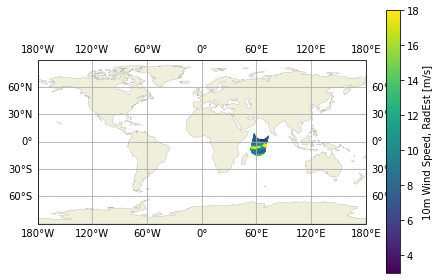

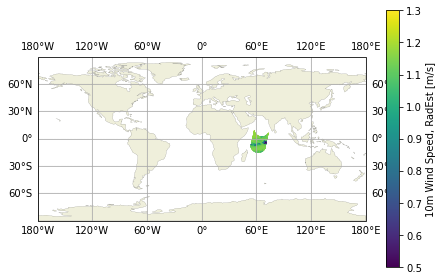

In [22]:
mapPlotScat(world_lons, world_lats, world_wind_radEst,
                 'World_wind_RadEst_Plat', 3,18)
mapPlotScat(world_lons, world_lats, world_wind_err_radEst,
                 'World_wind_Err_RadEst_Plat',0.5,1.3)

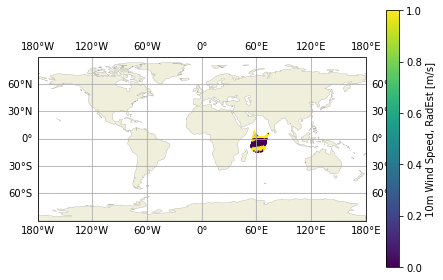

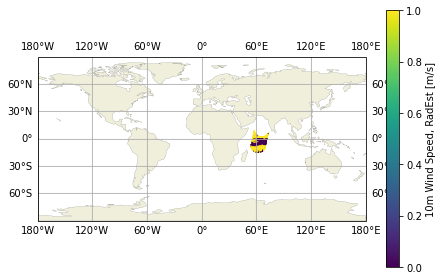

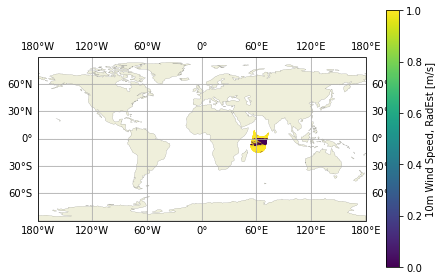

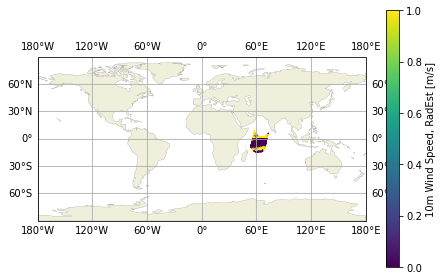

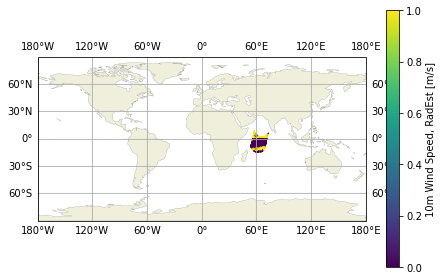

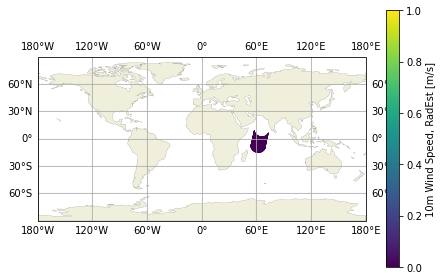

In [23]:
# If statistical tests performed:
mapPlotScat(world_lons, world_lats, world_wind_chis1_radEst,
                 'World_chisqu1_RadEst_Plat',0,1)
mapPlotScat(world_lons, world_lats, world_wind_chis2_radEst,
                 'World_chisqu2_RadEst_Plat',0,1)
mapPlotScat(world_lons, world_lats, world_wind_chis3_radEst,
                 'World_chisqu3_RadEst_Plat',0,1)
mapPlotScat(world_lons, world_lats, world_wind_chis4_radEst,
                 'World_chisqu4_RadEst_Plat',0,1)

mapPlotScat(world_lons, world_lats, world_wind_chisALL_radEst,
                 'world_wind_chisALL_radEst',0,1)
mapPlotScat(world_lons, world_lats, world_wind_chisT0andT1_radEst,
                 'world_wind_chisT0andT1_radEst',0,1)

In [ ]:
# Creation of area of interest:
#corners = {"min_lon": 25 , "max_lon": 75, "min_lat": -30 , "max_lat": 0, "lat_0": 60, "lon_0":-15}
corners = {"min_lon": -160 , "max_lon": -125, "min_lat": 30 , "max_lat": 60, "lat_0": 0, "lon_0":0}
proj_id = 'eqc'  # eqc
datum = 'WGS84'
area_interest = defineArea(corners, proj_id, datum)
grid_lons_zoom, grid_lats_zoom = area_interest.get_lonlats()

In [ ]:
zoom_lons, zoom_lats, zoom_wind_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind.values,
                            radius_of_influence=1000)
zoom_lons, zoom_lats, zoom_wind_err_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.wind_err.values,
                            radius_of_influence=1000)
zoom_lons, zoom_lats, zoom_chiSquareTest1_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest1.values,
                            radius_of_influence=1000)
zoom_lons, zoom_lats, zoom_chiSquareTest2_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest2.values,
                            radius_of_influence=1000)
zoom_lons, zoom_lats, zoom_chiSquareTest3_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest3.values,
                            radius_of_influence=1000)
zoom_lons, zoom_lats, zoom_chiSquareTest4_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chiSquareTest4.values,
                            radius_of_influence=1000)
# Some diagnostics:
zoom_lons, zoom_lats, zoom_chisALL_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chisALL.values,
                            radius_of_influence=1000)
zoom_lons, zoom_lats, zoom_chisT0andT1_radEst = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_zoom, grid_lats_zoom,
                            lons_radEst, lats_radEst, DS_CMSAF_ocean.chisT0andT1.values,
                            radius_of_influence=1000)



In [ ]:
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_wind_radEst,
                 'zoom_wind_RadEst_Plat', 3,18,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_wind_err_radEst,
                 'zoom_wind_err_radEst', 0.5,1.3,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_chiSquareTest1_radEst,
                 'zoom_chiSquareTest1_radEst', 0,1,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_chiSquareTest2_radEst,
                 'zoom_chiSquareTest2_radEst', 0,1,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_chiSquareTest3_radEst,
                 'zoom_chiSquareTest3_radEst', 0,1,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_chiSquareTest4_radEst,
                 'zoom_chiSquareTest4_radEst', 0,1,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_chisALL_radEst,
                 'zoom_chisALL_radEst', 0,1,area=area_interest)
mapPlotScatZoom(zoom_lons, zoom_lats, zoom_chisT0andT1_radEst,
                 'zoom_chisT0andT1_radEst', 0,1,area=area_interest)

In [ ]:
def get_TB_frame(BT_scene_env1, area_interest, begin_t, end_t):
    
    lat_scene1 = supporting_routines_m.generate_masked_array(BT_scene_env1.lat[begin_t:end_t,:],
                                                  BT_scene_env1.sft[begin_t:end_t,:], 0, '==', drop= False) 
    lon_scene1 = supporting_routines_m.generate_masked_array(BT_scene_env1.lon[begin_t:end_t,:],
                                                  BT_scene_env1.sft[begin_t:end_t,:], 0, '==', drop= False) 
    tb_scene1 = supporting_routines_m.generate_masked_array(BT_scene_env1.tb[begin_t:end_t,:,:],
                                                  BT_scene_env1.sft[begin_t:end_t,:], 0, '==', drop= False) 

    grid_lons_interest, grid_lats_interest = area_interest.get_lonlats()

    swath_scene1 = SwathDefinition(lons=lon_scene1, lats=lat_scene1)
    lons_scene1, lats_scene1 = swath_scene1.get_lonlats()

    reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1 = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_interest, grid_lats_interest,
                            lons_scene1, lats_scene1, tb_scene1.values,
                            radius_of_influence=3000)

    return reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1
    #swath_reduced_scene1 = SwathDefinition(reduced_lons_scene1, reduced_lats_scene1)

In [ ]:
# Creation of area of interest:
#corners = {"min_lon": 25 , "max_lon": 75, "min_lat": -30 , "max_lat": 0, "lat_0": 60, "lon_0":-15}
corners = {"min_lon": -95 , "max_lon": 20, "min_lat": 3 , "max_lat": 50, "lat_0": 27, "lon_0":-57}
proj_id = 'eqc'  # eqc
datum = 'WGS84'
area_interest = defineArea(corners, proj_id, datum)

In [ ]:

area_def_world = load_area('areas.yaml', 'worldeqc30km70')# 'worldeqc30km70') # for plots
grid_lons_world, grid_lats_world = area_def_world.get_lonlats()

In [ ]:
def timeMapAnimScat(BT_scene, BT_attributes, channel, area, 
                      init_date, nFrames, delta_hours, namefile):
    # Make a Mercator map of the data using Cartopy
    
    import matplotlib.animation as animation

    crs = area.to_cartopy_crs()
    
    #fig2 = plt.subplots(1,2) 
    fig = plt.figure(frameon=False) #figsize=(8, 6))
    fig.add_axes([0,0,1,1])
    ax = plt.axes(projection=crs)  
    ax.set_global()
    gl = ax.gridlines()  
    ax.set_title("TB "+namefile)
    #ax.set_title("Wind Speed "+namefile)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black') 
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER 


    #delta_hours = 12
    end_date = init_date + np.timedelta64(delta_hours, 'h') 
    time_slice = np.where((BT_attributes.time.values>=init_date)&(
        BT_attributes.time.values<end_date))
    begin_t = time_slice[0][0]  
    end_t = time_slice[0][-1]

    x, y, data = get_TB_frame(BT_scene, area, begin_t, end_t)
    
    ims = []
    im1 = plt.scatter(
            x,
            y,
            c=data[:,channel],
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            #vmin=3, vmax=12     # 180, 270
            vmin=130, vmax=270     # 180, 270
        ) 
    
    #fig.colorbar(im1).set_label("10m Wind Speed [m/s]")
    #fig.colorbar(im1).set_label("Temp. Bright. [K]") 
    
    for i in np.arange(nFrames):

        im1 = plt.scatter(
            x,
            y,
            c=data[:,channel],
            s=0.15,
            cmap="viridis",
            transform=ccrs.PlateCarree(),
            #vmin=3, vmax=12  # 180, 270
            vmin=130, vmax=270  # 180, 270
        ) 
        
        ims.append([im1])
        init_date = init_date + np.timedelta64(delta_hours, 'h') 
        end_date = end_date + np.timedelta64(delta_hours, 'h') 
        time_slice = np.where((BT_attributes.time.values>=init_date)&(
            BT_attributes.time.values<end_date))
        begin_t = time_slice[0][0]  
        end_t = time_slice[0][-1] 
        x, y, data = get_TB_frame(BT_scene, area, begin_t, end_t)

        
    im_ani = animation.ArtistAnimation(fig, ims, interval=500, repeat_delay=3000,
                                   blit=True)
    # To save this second animation with some metadata, use the following command:
    # im_ani.save('im.mp4', metadata={'artist':'Guido'})
    plt.tight_layout()
    im_ani.save(namefile+'.mp4',dpi=150)
    plt.show()

In [ ]:
nFrames = 12
delta_hours = 12
channel = 2
namefile = 'env1_22V_12h_F16'
timeMapAnimScat(BT_scene, BT_attributes, channel, area_interest, 
                      init_date, nFrames, delta_hours, namefile)

In [ ]:
# Resample swath scene 1 at a world wide scale:

result_scene1 = resample_nearest(swath_scene1, tb_scene1.values, area_def_world, 
                          radius_of_influence=30000, fill_value=np.nan)

#result_scene2 = resample_nearest(swath_scene2, tb_scene2.values, area_def_world, 
#                          radius_of_influence=30000, fill_value=np.nan)

In [ ]:
# Mask out swath part that intersects the area of interest


#reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2 = \
#                           data_reduce.swath_from_lonlat_grid(grid_lons_interest, grid_lats_interest,
#                            lons_scene2, lats_scene2, tb_scene2.values,
#                            radius_of_influence=3000)
#swath_reduced_scene2 = SwathDefinition(reduced_lons_scene2, reduced_lats_scene2)

In [ ]:
# Mask out swath part that intersects the area of interest
world_lons_scene1, world_lats_scene1, world_data_scene1 = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_scene1, lats_scene1, tb_scene1.values,
                            radius_of_influence=3000)
swath_world_scene1 = SwathDefinition(reduced_lons_scene1, reduced_lats_scene1)

world_lons_scene2, world_lats_scene2, world_data_scene2 = \
                           data_reduce.swath_from_lonlat_grid(grid_lons_world, grid_lats_world,
                            lons_scene2, lats_scene2, tb_scene2.values,
                            radius_of_influence=3000)
swath_world_scene2 = SwathDefinition(reduced_lons_scene2, reduced_lats_scene2)

In [ ]:
# Resample swath data into a grid in the area of interest 
result_reduced_scene1 = resample_nearest(swath_reduced_scene1, reduced_data_scene1, area_interest, 
                                  radius_of_influence=30000, fill_value=None)

result_reduced_scene2 = resample_nearest(swath_reduced_scene2, reduced_data_scene2, area_interest, 
                                  radius_of_influence=30000, fill_value=None)

In [ ]:
mapArea('mapArea0', area_def_world)
mapArea('mapArea01', area_interest)

In [ ]:
chann = 0
# Plot resampled (grid version) scenes:
basicMapPlot(result_scene1[:,:,chann],'scene1'+str(chann), area_def_world)  # map of the whole world, grid
basicMapPlot(result_reduced_scene1[:,:,chann],
             'scene1_reduced'+str(chann), area_interest)  # map only the area of interest, grid

basicMapPlot(result_scene2[:,:,chann],'scene2'+str(chann), area_def_world)  # map of the whole world, grid
basicMapPlot(result_reduced_scene2[:,:,chann],
             'scene2_reduced'+str(chann), area_interest)  # map only the area of interest, grid

In [ ]:
# Plot in area of interest, Plate Carree projection

chann = 0
# Plot original swath pixels:
basicMapPlotScat(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'scene1_scatt_PCarr_19H', area_interest, )
chann = 1
# Plot original swath pixels:
basicMapPlotScat(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'scene1_scatt_PCarr_19V', area_interest, )
chann = 2
# Plot original swath pixels:
basicMapPlotScat(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'scene1_scatt_PCarr_22V', area_interest, )
#chann = 1
#basicMapPlotScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
#                 'scene2_scatt_PCarr_91V', area_interest)

In [ ]:
image_path = Path('/nobackup/users/echeverr/fortran_tests/netcdf/following_Edouard/imgs/ch19H')
images = list(image_path.glob('*.png'))
image_list = []
for file_name in images:
    image_list.append(imageio.imread(file_name))

In [ ]:
imageio.mimwrite('animated_from_images.gif', image_list)

In [ ]:
# Plot in world area, Orthographic projection

chann = 2
# Plot original swath pixels:
basicMapPlotScat1(reduced_lons_scene1, reduced_lats_scene1, reduced_data_scene1[:,chann],
                 'world_scene1_scatt_Orth_22V', area_interest)
#chann = 3
#basicMapPlotScat1(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
#                 'world_scene1_scatt_Orth_91H', area_interest)

In [ ]:
# Plot original swath pixels:
chann = 2
basicMapPlotScat1(world_lons_scene1, world_lats_scene1, world_data_scene1[:,chann],
                 'scene1_scatt_Orth_world_22V', area_def_world)
chann = 3
basicMapPlotScat1(world_lons_scene2, world_lats_scene2, world_data_scene2[:,chann],
                 'scene1_scatt_Orth_world_91H', area_def_world)

In [ ]:
def basicMapPlot(result,namefile, area):
    crs = area.to_cartopy_crs()
    fig, ax = plt.subplots(figsize=(13, 3))
    ax= plt.axes(projection=crs)
    #ax.background_img(name='BM', resolution='high') 
    ax.coastlines();
    #ax.stock_img();
    ax.grid(True)
    #ax.set_xlabel('Longitude [deg]')
    #ax.set_ylabel('Latitude [deg]')

    #gl = ax.gridlines(crs=ccrs.Orthographic(), linewidth=0.1, 
    #                  color='black', alpha=0.5, linestyle='--', draw_labels=True)
    #gl.xlabels_top = False
    #gl.ylabels_left = False
    #gl.ylabels_right=True
    #gl.xlines = True
    #gl.xlocator = mticker.FixedLocator([70, 75, 80, 85])
    #gl.ylocator = mticker.FixedLocator([-5, -3, -1, 1, 3])
    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER

    im = ax.imshow(result, transform=crs, extent=crs.bounds, origin='upper', cmap='jet', vmin=150, vmax=250)
    fig.colorbar(im,ax=ax) 
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=150)  


In [ ]:
def basicMapPlotScat(x,y,data,namefile, area):
    # Make a Mercator map of the data using Cartopy
    
    crs = area.to_cartopy_crs()
    
    fig = plt.figure(figsize=(8, 6))
    #plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=crs)   
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    ax.set_global()
    ax.gridlines()        
    ax.set_title("TB")
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.1, 
                      color='black', alpha=0.5, linestyle='--', draw_labels=True)
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER    

    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        x,
        y,
        c=data,
        s=0.15,
        cmap="viridis",
        transform=ccrs.PlateCarree(),
        #vmin=3, vmax=18         #180, 270
        vmin=130, vmax=270         #180, 270
    )
    fig.colorbar(im).set_label("Brightness temperature [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=150)  

In [ ]:
def mapArea(namefile, area):

    crs = area.to_cartopy_crs()
    fig, ax = plt.subplots(figsize=(13, 3))
    ax= plt.axes(projection=crs)
    
    #gl = ax.gridlines(crs=ccrs.Orthographic(), linewidth=0.1, 
    #                  color='black', alpha=0.5, linestyle='--', draw_labels=True)

    #gl.xformatter = LONGITUDE_FORMATTER
    #gl.yformatter = LATITUDE_FORMATTER
    
    ax.coastlines(linewidth=0.5)   
    #ax.set_global() 
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=300)  

In [ ]:
#chann = 0
#basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
#                 'scene1_scatt'+str(chann), area_interest)

nFrames = 150
start_frame = 0
nAcrossSwathFrame = 180

chann = 0
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_19H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_91V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_22V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 3
basicMapAnimScat(reduced_lons_scene2, reduced_lats_scene2, reduced_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_red_91H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

In [ ]:
def basicMapAnimScat(x,y,data,namefile, area, 
                      nFrames, start_frame, nAcrossSwathFrame):
    # Make a Mercator map of the data using Cartopy
    
    import matplotlib.animation as animation

    crs = area.to_cartopy_crs()
    
    #fig2 = plt.subplots(1,2) 
    fig = plt.figure(figsize=(8, 6))
    ax = plt.axes(projection=crs)  
    ax.set_global()
    gl = ax.gridlines()  
    #ax.set_title("TB "+namefile)
    ax.set_title("Wind Speed "+namefile)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
   
    #gl0 = ax.gridlines(crs=ccrs.PlateCarree(), linewidth=0.1, 
    #                  color='black', alpha=0.5, linestyle='--', draw_labels=True)

    #gl0.xformatter = LONGITUDE_FORMATTER
    #gl0.yformatter = LATITUDE_FORMATTER 
    
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER 
    
    start_ = start_frame
    end_ = nAcrossSwathFrame
    
    ims = []
    x2 = x[start_:end_]
    y2 = y[start_:end_]
    data2_0 = data[start_:end_]
    #data2_2 = data[start_:end_,2]

    im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            vmin=3, vmax=12     # 180, 270
            #vmin=130, vmax=270     # 180, 270
        ) 
    fig.colorbar(im1).set_label("10m Wind Speed [m/s]")
    #fig.colorbar(im1).set_label("Temp. Bright. [K]") 
    for i in np.arange(nFrames):
        #ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

        im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            transform=ccrs.PlateCarree(),
            vmin=3, vmax=12  # 180, 270
            #vmin=130, vmax=270  # 180, 270
        ) 

        ims.append([im1])
      
        
        start_ +=nAcrossSwathFrame
        end_ +=nAcrossSwathFrame
        x2 = np.append(x2,x[start_:end_])
        y2 = np.append(y2,y[start_:end_])
        data2_0 = np.append(data2_0,data[start_:end_])
        #data2_2 = np.append(data2_2,data[start_:end_,2])

        
    im_ani = animation.ArtistAnimation(fig, ims, interval=50, repeat_delay=3000,
                                   blit=True)
    # To save this second animation with some metadata, use the following command:
    # im_ani.save('im.mp4', metadata={'artist':'Guido'})
    im_ani.save(namefile+'_bar.mp4',dpi=150)
    plt.show()

In [ ]:
BT_scene_env2 

In [ ]:
def basicMapPlotScat1(x,y,data,namefile, area):
    # Make a Mercator map of the data using Cartopy
    
    fig = plt.figure()
    
    ortho = ccrs.Orthographic(60,-15)
    ax = plt.axes(projection=ortho)
    
    crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.Geodetic()
    #crs = ccrs.Orthographic(60,-15)
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()    
    
    #ax.set_title("TB")
    #ax.coastlines() 
    # Plot the air temperature as colored circles and the wind speed as vectors.
    im = ax.scatter(
        xy[:,0],
        xy[:,1],
        c=data,
        s=0.15,
        cmap="viridis",
        #transform=crs,
        #vmin=3, vmax=18,  # 180, 270
        vmin=130, vmax=270,  # 180, 270        
    )
    #fig.colorbar(im).set_label("10m Wind Speed, HOAPS [m/s]")
    fig.colorbar(im).set_label("Temp. Bright [K]")
    
# Use an utility function to add tick labels and land and ocean features to the map.

    plt.tight_layout()
    #plt.show()
    plt.savefig(namefile+'.png', bbox_inches='tight', dpi=300)  

In [ ]:
nFrames = 1200
start_frame = 0
nAcrossSwathFrame = 180

chann = 0
basicMapAnimScat1(world_lons_scene1, world_lats_scene1, world_data_scene1[:,chann],
                 'An_scene1_scatt_Orth_world_19H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat1(world_lons_scene2, world_lats_scene2, world_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_world_91V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 2
basicMapAnimScat1(world_lons_scene1, world_lats_scene1, world_data_scene1[:,chann],
                 'An_scene1_scatt_Orth_world_22V', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

chann = 3
basicMapAnimScat1(world_lons_scene2, world_lats_scene2, world_data_scene2[:,chann],
                 'An_scene1_scatt_Orth_world_91H', area_interest, 
                  nFrames, start_frame, nAcrossSwathFrame)

In [ ]:
def basicMapAnimScat1(x,y,data,namefile, area, 
                      nFrames, start_frame, nAcrossSwathFrame):
    # Make a Mercator map of the data using Cartopy
    
    import matplotlib.animation as animation

    fig = plt.figure(figsize=(8, 6))
    
    ortho = ccrs.Orthographic(-39,18) #ccrs.Orthographic(60,-15)
    ax = plt.axes(projection=ortho)
    
    crs = ccrs.RotatedPole(pole_longitude=177.5, pole_latitude=37.5)
    geo = ccrs.Geodetic()
    
    ax.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='black')
    
    xy = ortho.transform_points(geo, x, y)

    ax.set_global()
    ax.gridlines()        
       
    ax.set_title("Wind Speed "+namefile) 
    #ax.set_title("Temperature Brightness "+namefile) 
    
    start_ = start_frame
    end_ = nAcrossSwathFrame
    
    ims = []
    x2 = xy[start_:end_,0]
    y2 = xy[start_:end_,1]
    data2_0 = data[start_:end_]
    #data2_2 = data[start_:end_,2]

    im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            vmin=3, vmax=18  # 180, 250
            #vmin=130, vmax=270   # 180, 270 TB
        ) 
    fig.colorbar(im1).set_label("10m Wind Speed [m/s]")
    #fig.colorbar(im1).set_label("Temp. Bright. [K]") 
    for i in np.arange(nFrames):
        #ims.append((plt.pcolor(x, y, base + add, norm=plt.Normalize(0, 30)),))

        #plt.tight_layout()
        im1 = plt.scatter(
            x2,
            y2,
            c=data2_0,
            s=0.15,
            cmap="viridis",
            #transform=ccrs.PlateCarree(),
            vmin=3, vmax=18   # 180, 270 TB
            #vmin=130, vmax=270   # 180, 270 TB
        ) 

        ims.append([im1])
      
        
        start_ +=nAcrossSwathFrame
        end_ +=nAcrossSwathFrame
        x2 = np.append(x2,xy[start_:end_,0])
        y2 = np.append(y2,xy[start_:end_,1])
        data2_0 = np.append(data2_0,data[start_:end_])
        #data2_2 = np.append(data2_2,data[start_:end_,2])

        
    im_ani = animation.ArtistAnimation(fig, ims, interval=30, repeat_delay=3000,
                                   blit=True)
    # To save this second animation with some metadata, use the following command:
    # im_ani.save('im.mp4', metadata={'artist':'Guido'})
    im_ani.save(namefile+'.mp4',dpi=150)
    plt.show()